<a href="https://colab.research.google.com/github/zrd123/my_colab/blob/master/code/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 多层感知机从零实现

In [ ]:
# !pip install d2l==0.17.6

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

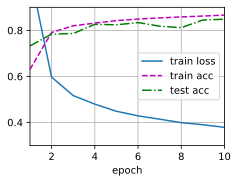

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

## 简洁实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 与softmax回归的简洁实现相比，添加了2个全连接层。第一层是隐藏层，它包含256个隐藏单元，并使用了ReLU激活函数。 第二层是输出层。
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

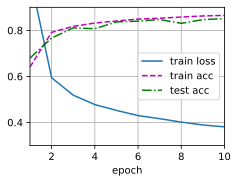

In [ ]:
# 训练过程的实现与我们实现softmax回归时完全相同， 这种模块化设计使我们能够将与模型架构有关的内容独立出来。
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 拟合

In [ ]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.5569],
         [-0.3714]]),
 tensor([[ 1.0000e+00,  5.5695e-01,  1.5509e-01,  2.8793e-02,  4.0090e-03,
           4.4656e-04,  4.1452e-05,  3.2981e-06,  2.2961e-07,  1.4209e-08,
           7.9135e-10,  4.0067e-11,  1.8596e-12,  7.9669e-14,  3.1694e-15,
           1.1768e-16,  4.0963e-18,  1.3420e-19,  4.1523e-21,  1.2172e-22],
         [ 1.0000e+00, -3.7144e-01,  6.8983e-02, -8.5410e-03,  7.9311e-04,
          -5.8918e-05,  3.6474e-06, -1.9354e-07,  8.9861e-09, -3.7087e-10,
           1.3775e-11, -4.6515e-13,  1.4398e-14, -4.1138e-16,  1.0914e-17,
          -2.7027e-19,  6.2743e-21, -1.3709e-22,  2.8289e-24, -5.5303e-26]]),
 tensor([5.3385, 4.4471]))

In [ ]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.978245   1.2101383 -3.3782053  5.5689006]]


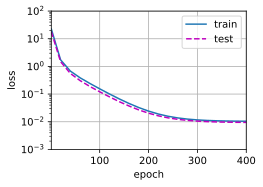

In [ ]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3507025 3.72202  ]]


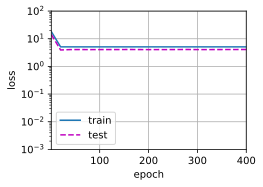

In [ ]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.971598    1.249824   -3.3228283   5.2377214  -0.27551588  1.306388
   0.07784136  0.23204371 -0.02917968 -0.07050106  0.03267606  0.09271716
   0.21228474 -0.04103164 -0.03618662 -0.08188475 -0.17284904 -0.15312368
   0.08748363  0.08944522]]


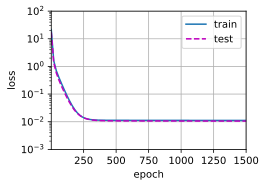

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 权重衰退

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2
def l1_penalty(w):
    return torch.sum(torch.abs(w))

In [ ]:
def train(lambd, L2=True):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 150, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            if L2==True:
              l = loss(net(X), y) + lambd * l2_penalty(w)
            else:
              l = loss(net(X), y) + lambd * l1_penalty(w)

            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    if L2 == True:
      print('w的L2范数是：', torch.norm(w).item())
    else:
      print('w的L1范数是：', torch.norm(w).item())

w的L2范数是： 13.999178886413574


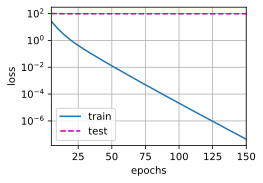

In [ ]:
#过拟合
train(lambd=0)

w的L1范数是： 13.880916595458984


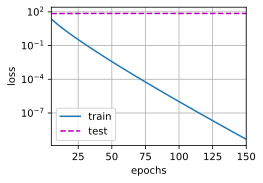

In [ ]:
train(0,False)

w的L2范数是： 0.04387431964278221


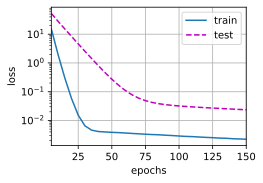

In [ ]:
train(lambd=5)

w的L1范数是： 0.07500740885734558


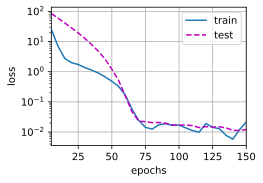

In [ ]:
train(3,False)

## 简洁实现

In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.549293518066406


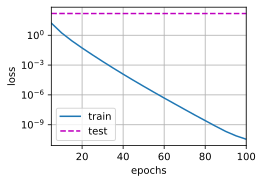

In [ ]:
train_concise(0)

w的L2范数： 0.6223913431167603


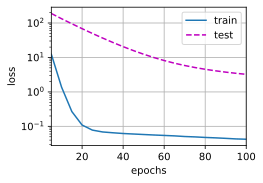

In [ ]:
train_concise(3)

# 丢弃法

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [ ]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  0.,  0., 12., 14.],
        [ 0.,  0., 20., 22.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [ ]:
# 定义模型
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

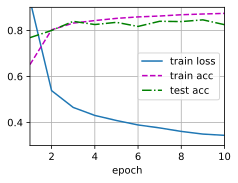

In [ ]:
# 训练测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

In [ ]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

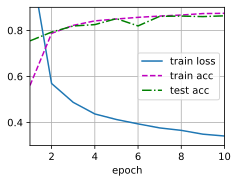

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)